In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import utils
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import time
import piq
import torchsummary
import random
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

## Загрузка данных
Пути к данным и разделение обучающей выборки на train и validation.

In [3]:
DATASET_PATH = Path("dataset/")
TRAIN_DATASET_PATH = DATASET_PATH / "train_preprocessing"
TRAIN_HR = TRAIN_DATASET_PATH / "HR"
TRAIN_LR = TRAIN_DATASET_PATH / "LR"
RESULTS_ROOT = "tensorboard_results"
TENSORBOARD_TAG = "simple_mask_2"

In [4]:
X = np.array([path for path in TRAIN_HR.iterdir()])
y = np.array([path for path in TRAIN_LR.iterdir()])
X.sort()
y.sort()

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Класс датасета
К изображениям для обучения применяются аугментации отражения и поворотов на 90, 270, 180 градусов.
Обучение производится на обрезанных изображениях, валидация по полным.

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

rotate = [Image.ROTATE_90, Image.ROTATE_180, Image.ROTATE_270, None]

class ImagesDataset(Dataset):

    def __init__(self, hr_images_paths, lr_images_paths, transform=None, crop_size=None, flip=False, rotate=False, dataset_len=None):
        self._transform = transform
        self._hr_images_paths = hr_images_paths
        self._lr_images_paths = lr_images_paths
        self._crop_size = crop_size
        self._flip = flip
        self._rotate = rotate
        self._dataset_len = dataset_len
        
    def __getitem__(self, i):
        
        if self._dataset_len:
            i = i % len(self._hr_images_paths)
        
        image_hr = Image.open(self._hr_images_paths[i])
        image_lr = Image.open(self._lr_images_paths[i])
        
        if self._flip:
            random_horizontal_flip = random.random()
            random_vertical_flip = random.random()
            if (random_horizontal_flip < 0.5):
                image_hr = image_hr.transpose(Image.FLIP_TOP_BOTTOM)
                image_lr = image_lr.transpose(Image.FLIP_TOP_BOTTOM)
            if (random_vertical_flip < 0.5):
                image_hr = image_hr.transpose(Image.FLIP_LEFT_RIGHT)
                image_lr = image_lr.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self._rotate:
            random_rotate = random.randint(0, 3)
            if rotate[random_rotate] != None:
                image_hr = image_hr.transpose(rotate[random_rotate])
                image_lr = image_lr.transpose(rotate[random_rotate])            

        if self._transform:
            image_hr = self._transform(image_hr)
            image_lr = self._transform(image_lr)
            
        if self._crop_size is not None:
            x_start = np.random.randint(0, image_lr.shape[1] - self._crop_size)
            y_start = np.random.randint(0, image_lr.shape[2] - self._crop_size)

            image_lr = image_lr[
                       :,
                       x_start:x_start + self._crop_size,
                       y_start:y_start + self._crop_size]
            image_hr = image_hr[
                       :,
                       x_start * 2:x_start * 2 + self._crop_size * 2,
                       y_start * 2:y_start * 2 + self._crop_size * 2]
            
        return (image_hr, image_lr)

    def __len__(self):
        if self._dataset_len:
            return self._dataset_len
        return len(self._hr_images_paths)

train_dataset = ImagesDataset(X_train, y_train, transform, crop_size=128, flip=True, rotate=True)#, dataset_len=3000)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=25,
    shuffle=True
)

validation_dataset = ImagesDataset(X_validation, y_validation, transform)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle=False
)

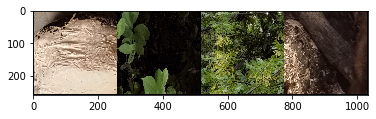

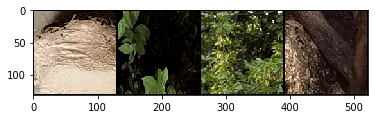

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, outputs = next(iter(train_loader))
inp = utils.make_grid(inputs[:4])
out = utils.make_grid(outputs[:4])
imshow(inp)
imshow(out)

## Модель

Модель представляет собой сверточную нейронную сеть, которая является маской, накладывающейся на изображение, уменьшенное классическим способом.

In [7]:
class Net(nn.Module):
    def __init__(self, features=32):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=features, kernel_size=3, padding=1)
        self.activation1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, stride=2, padding=1)
        self.activation2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(features)
        self.conv3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3,  padding=1)
        self.activation3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(features)
        self.conv4 = nn.Conv2d(in_channels=features, out_channels=3, kernel_size=3, padding=1)
        
    def forward(self, x):
        y = F.interpolate(x, size=(x.shape[2] // 2, x.shape[3] // 2), mode='area')
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation3(x)
        x = self.conv4(x)
        im = y + x
        return im, x
    
net = Net()

## Обучение

В процессе обучения использовался оптимизатор Adam. В качестве loss функции использовалась сумма 1e-3 * vgg loss и MSE по маске.
При валидации сохранялась модель с наименьшим значением loss функции.

In [8]:
def loss_function(criterion_vgg):
    def loss(mask, lr_images, predictions):
        loss_mask = ((mask - (lr_images - predictions))**2).mean()
        loss_vgg = 1e-3 * criterion_vgg(predictions, lr_images)
        return loss_mask + loss_vgg
    return loss

In [9]:
def train(net, train_dataloader, optimizer, loss_f, writer, device):
    train_losses = []
    for hr_images, lr_images in tqdm(train_dataloader):
        net = net.train()
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        optimizer.zero_grad()
        predictions, mask = net(hr_images)
        loss = loss_f(mask, lr_images, predictions)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().detach().item())
    train_loss = np.mean(train_losses)
    writer.add_scalar("train_loss_plot", train_loss, global_step=epoch_id)
    print("train_loss:", train_loss)    

In [10]:
def validate(net, validation_dataloader, loss_f, writer, min_validation_loss, device):
    validation_losses = []
    pred_lr_image = None
    for hr_images, lr_images in tqdm(validation_dataloader):
        net = net.eval()
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        with torch.no_grad():
            predictions, mask = net(hr_images)               
            if pred_lr_image is None:
                pred_lr_image = predictions[0, :, :, :].clamp(0, 1)
            loss = loss_f(mask, lr_images, predictions)
            validation_losses.append(loss.cpu().detach().item())
    validation_loss = np.mean(validation_losses)
    if (validation_loss < min_validation_loss):
        min_validation_loss = validation_loss
        torch.save(net.state_dict(), TENSORBOARD_TAG + ".best.pth")
        print("Model was saved")
    writer.add_image('test_lr_image', pred_lr_image, epoch_id)
    writer.add_scalar("test_loss_plot", validation_loss, global_step=epoch_id)
    print("test_loss:", validation_loss)
    return min_validation_loss

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHES = 1000
net = net.to(DEVICE)
optimizer = Adam(net.parameters(), lr=1e-3)
writer = SummaryWriter(Path(RESULTS_ROOT) / TENSORBOARD_TAG)
criterion_vgg = piq.ContentLoss().to(DEVICE)
min_validation_loss = 100
for epoch_id in range(EPOCHES):
    print("Epoch:", epoch_id)
    train(net, train_loader, optimizer, loss_function(criterion_vgg), writer, DEVICE)
    min_validation_loss = validate(net, validation_loader, loss_function(criterion_vgg), writer, min_validation_loss, DEVICE)        

Epoch: 0



train_loss: 3.744564164768566



Model was saved
test_loss: 0.8504438277172006
Epoch: 1



train_loss: 1.3914620226079768



test_loss: 0.8967059515956519
Epoch: 2


KeyboardInterrupt: 

## Генерация test\LR

In [ ]:
net.load_state_dict(torch.load(TENSORBOARD_TAG + ".best.pth"))

In [ ]:
TEST_DATASET_PATH = DATASET_PATH / "test"
TEST_HR = TEST_DATASET_PATH / "HR"
TEST_LR = TEST_DATASET_PATH / "LR"

In [ ]:
os.makedirs(TEST_LR, exist_ok=True)

In [ ]:
net = net.cpu().eval()

In [ ]:
for path_to_image in tqdm(list(TEST_HR.iterdir())):
    image = transform(Image.open(path_to_image))
    img = image.unsqueeze(0)
    with torch.no_grad():
        result, _ = net(img.to("cpu"))
    result_image = transforms.ToPILImage()(result[0].to("cpu").clamp(0, 1))
    result_image.save(str(Path(TEST_LR / path_to_image.name))) 
    del result
    del img
    del image
    del result_image